# Flair NER Tagging Pipeline

## Navigation:
* [General Info](#info)
* [Preparing Dataset](#prepare)
* [Adding BIOES Annotation](#bioes)
* [Training with Flair](#train)
* [Using Trained Model for Prediction](#predict)
* [Prediction and Saving to CONLL-U](#save)

## General Info <a class="anchor" id="info"></a>

`Libraries needed:` `corpuscula.conllu` (conllu parsing); `flair` (training); `json` (saving results); `tqdm` (displaying progress)

`Pre-Trained Embeddings used in this example:` [DeepPavlov Wiki+Lenta](http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin). Preprocessing included: `nltk wordpunсt_tokenize`

`Pipeline Input:` CONLL-U parsed text file.

`Processing:` Extracting tokens and named entities as separate lists of lists of strings, and adding BIOES tags to entities.

`Train Input:` `{train,dev,test}.txt` files in BIOES format as shown [here](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging))

`Sample train input:`
```
здравствуйте O
расскажите O
справочной S-Department
аэропорта S-Organization
город B-Geo
томск E-Geo
```

`Sample inference (predict) result:`
```
4 <B-Organization> больница <I-Organization> детская <I-Organization> городская <I-Organization> больница <I-Organization> номер <I-Organization> 4 <E-Organization> города <B-Geo> сочи <E-Geo> приемный <B-Department> покой <E-Department>
```

`Pipeline Output:` JSON with NER Parsing (list of lists of dict)

`Sample pipeline output:`
```
[[{'word': 'здравствуйте', 'entity': None},
  {'word': 'будьте', 'entity': None},
  {'word': 'добры', 'entity': None},
  {'word': 'подскажите', 'entity': None},
  {'word': 'мне', 'entity': None},
  {'word': 'регистратуру', 'entity': 'Department'},
  {'word': 'кожно', 'entity': 'Organization'},
  {'word': 'венерического', 'entity': 'Organization'},
  {'word': 'диспансера', 'entity': 'Organization'}],
  <...>]
```

## Preparing Dataset <a class="anchor" id="prepare"></a>

In [1]:
from corpuscula.conllu import Conllu

In [2]:
def read_corpus(corpus=None, silent=False):
    if isinstance(corpus, str):
        corpus = Conllu.load(corpus, **({'log_file': None} if silent else{}))
    elif callable(corpus):
        corpus = corpus()

    parsed_corpus = []
    parsed_ne = []
    
    for sent in corpus:
        curr_sent = [x['FORM'] for x in sent[0] if x['FORM'] and '-' not in x['ID']]
        curr_ne = [x['MISC']['NE'] if 'NE' in x['MISC'].keys() else 'O' for x in sent[0]]
        parsed_corpus.append(curr_sent)
        parsed_ne.append(curr_ne)
    
    return parsed_corpus, parsed_ne

In [3]:
# replace file names, if necessary
parsed_corpus_train, named_entities_train = read_corpus('result_ner_train.conllu')
parsed_corpus_dev, named_entities_dev = read_corpus('result_ner_dev.conllu')
parsed_corpus_test, named_entities_test = read_corpus('result_ner_test.conllu')

Load corpus
[===============================] 30390                             
Corpus has been loaded: 30390 sentences, 378829 tokens
Load corpus
[====] 3799                                                        
Corpus has been loaded: 3799 sentences, 47280 tokens
Load corpus
[====] 3798                                                        
Corpus has been loaded: 3798 sentences, 47126 tokens


In [4]:
parsed_corpus_train[:1], named_entities_train[:1]

([['добрый',
   'день',
   'девушка',
   'скажите',
   'пожалуйста',
   'мне',
   'телефончик',
   'автобусная',
   'да',
   'по',
   'бежецкого']],
 [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'Organization', 'O', 'O', 'Address']])

## Adding BIOES Annotation <a class="anchor" id="bioes"></a>

In [5]:
def bioes_annotation(ne_list):    

    # Adding BIOES-annotation for future training with Flair 
    
    prev_ne = 'O'
    bioes_ne = []
    
    for i, ne in enumerate(ne_list):
        if ne == 'O':
            prev_ne = 'O'
            
        elif prev_ne == 'O' or ne != prev_ne.split('-')[1]:
            if i < len(ne_list)-1 and ne == ne_list[i+1]:
                ne = 'B-' + ne   
            else:
                ne = 'S-' + ne

        elif ne == prev_ne.split('-')[1] and prev_ne.split('-')[0] in ['B', 'I']:
            if i < len(ne_list)-1 and ne == ne_list[i+1]:
                ne = 'I-' + ne
            else:
                ne = 'E-' + ne
                    
        prev_ne = ne
        bioes_ne.append(ne)
    
    return bioes_ne

In [6]:
bio_ne_train = [bioes_annotation(ne_seq) for ne_seq in named_entities_train]
bio_ne_dev = [bioes_annotation(ne_seq) for ne_seq in named_entities_dev]
bio_ne_test = [bioes_annotation(ne_seq) for ne_seq in named_entities_test]

In [7]:
bio_ne_train[:1]

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-Organization', 'O', 'O', 'S-Address']]

In [8]:
# Modify paths and file names, if necessary
import os

dn = './ner_bioes/'
if not os.path.isdir(dn):
    os.mkdir(dn)

with open(os.path.join(dn, 'train.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(parsed_corpus_train)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(parsed_corpus_train[i],
                                                              bio_ne_train[i]))]),
               file=f)]
        print(file=f)

with open(os.path.join(dn, 'dev.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(parsed_corpus_dev)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(parsed_corpus_dev[i],
                                                              bio_ne_dev[i]))]),
               file=f)]
        print(file=f)
        
with open(os.path.join(dn, 'test.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(parsed_corpus_test)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(parsed_corpus_test[i],
                                                              bio_ne_test[i]))]),
               file=f)]
        print(file=f)

## Training with Flair <a class="anchor" id="train"></a>

In [10]:
# Uncomment lines below to install Flair and download pre-trained
# embeddings if not done yet

#!pip install flair
#!wget -P ./resources http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin

In [10]:
import flair, torch
device = 'cuda:2'
flair.device = torch.device(device)
from flair.data import Corpus
from flair.datasets import ColumnCorpus
# need to figure out if these can be used with custom embeddings. Use FastTest for now.
# from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings 
from flair.embeddings import FastTextEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
import torch
import sys
from typing import List

In [11]:
# 1. Loading our corpus
# define columns (it is possible to add more columns, example: pos)
columns = {0: 'text', 1: 'ner'}

# this is the folder in which train, test and dev files reside
data_folder = './ner_bioes/'

# init a corpus using column format, data folder and the names 
# of the train, dev and test files
print('Loading a corpus...')
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='train.txt',
                              test_file='test.txt',
                              dev_file='dev.txt')
print(corpus)
print()

# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make a tag dictionary from the corpus
print('Make a tag dictionary...')
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)
print()

# 4. initialize embeddings
print('Loading embeddings...', end='')
embeddings = FastTextEmbeddings(
    './resources/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin'
)
print(' done.')

# 5. initialize sequence tagger
tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

Loading a corpus...
2020-04-03 23:08:15,500 Reading data from ner_bioes
2020-04-03 23:08:15,502 Train: ner_bioes/train.txt
2020-04-03 23:08:15,502 Dev: ner_bioes/dev.txt
2020-04-03 23:08:15,502 Test: ner_bioes/test.txt
Corpus: 30390 train + 3799 dev + 3798 test sentences

Make a tag dictionary...
Dictionary with 55 tags: <unk>, O, S-Organization, S-Address, B-Department, E-Department, B-Organization, E-Organization, S-Person, B-Address, E-Address, S-PersonProperty, I-Organization, S-Goal, B-Geo, E-Geo, S-Department, I-Address, B-Facility, I-Facility, E-Facility, S-Geo, B-Goal, I-Goal, E-Goal, B-PersonProperty, E-PersonProperty, I-Department, S-Facility, I-Geo

Loading embeddings... done.


In [12]:
# 6. initialize trainer
"""
Initialize a model trainer
:param model: The model that you want to train. The model should
              inherit from flair.nn.Model
:param corpus: The dataset used to train the model, should be of type Corpus
:param optimizer: The optimizer to use (typically SGD or Adam) [SGD by default]
:param epoch: The starting epoch (normally 0 but could be higher
              if you continue training model)
:param use_tensorboard: If True, writes out tensorboard information
"""
trainer: ModelTrainer = ModelTrainer(model=tagger,
                                     corpus=corpus)
#checkpoint = 'resources/taggers/example-ner/checkpoint.pt'
#trainer = ModelTrainer.load_checkpoint(checkpoint, corpus)

# 7. start training
'''
All possible parameters (with default values):
        learning_rate: float = 0.1,
        mini_batch_size: int = 32,
        mini_batch_chunk_size: int = None,
        max_epochs: int = 100,
        anneal_factor: float = 0.5,
        patience: int = 3,
        min_learning_rate: float = 0.0001,
        train_with_dev: bool = False,
        monitor_train: bool = False,
        monitor_test: bool = False,
        embeddings_storage_mode: str = 'cpu' (other modes: 'none', 'gpu')
        checkpoint: bool = False,  # if True, model training can be resumed later
        save_final_model: bool = True,
        anneal_with_restarts: bool = False,
        batch_growth_annealing: bool = False,
        shuffle: bool = True,
        param_selection_mode: bool = False,
        num_workers: int = 6,
        sampler=None,
        use_amp: bool = False,
        amp_opt_level: str = "O1",
        eval_on_train_fraction=0.0,
        eval_on_train_shuffle=False,
'''
trainer.train('resources/taggers/example-ner',
              learning_rate=0.1,
              mini_batch_size=32,
              embeddings_storage_mode='gpu',
              max_epochs=150)

2020-04-03 23:09:53,262 ----------------------------------------------------------------------------------------------------
2020-04-03 23:09:53,262 Model: "SequenceTagger(
  (embeddings): FastTextEmbeddings('ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin')
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=300, out_features=300, bias=True)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=55, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2020-04-03 23:09:53,263 ----------------------------------------------------------------------------------------------------
2020-04-03 23:09:53,263 Corpus: "Corpus: 30390 train + 3799 dev + 3798 test sentences"
2020-04-03 23:09:53,264 ----------------------------------------------------------------------------------------------------
2020-04-03 23:09:53,264 Parameters:
2020-04-03 23:09:53,264  -

2020-04-03 23:25:55,770 EPOCH 5 done: loss 3.1119 - lr 0.1000
2020-04-03 23:26:00,045 DEV : loss 2.326802968978882 - score 0.7661
2020-04-03 23:26:00,056 BAD EPOCHS (no improvement): 0
2020-04-03 23:27:24,561 ----------------------------------------------------------------------------------------------------
2020-04-03 23:27:34,446 epoch 6 - iter 95/950 - loss 3.00219901 - samples/sec: 310.49
2020-04-03 23:27:43,934 epoch 6 - iter 190/950 - loss 2.98072835 - samples/sec: 320.84
2020-04-03 23:27:53,491 epoch 6 - iter 285/950 - loss 3.00950369 - samples/sec: 318.45
2020-04-03 23:28:02,695 epoch 6 - iter 380/950 - loss 2.99896970 - samples/sec: 330.65
2020-04-03 23:28:11,835 epoch 6 - iter 475/950 - loss 2.97626362 - samples/sec: 332.98
2020-04-03 23:28:21,256 epoch 6 - iter 570/950 - loss 2.96375085 - samples/sec: 323.03
2020-04-03 23:28:30,710 epoch 6 - iter 665/950 - loss 2.95571721 - samples/sec: 321.89
2020-04-03 23:28:40,545 epoch 6 - iter 760/950 - loss 2.97405866 - samples/sec: 30

2020-04-03 23:45:18,021 epoch 12 - iter 190/950 - loss 2.56646013 - samples/sec: 326.70
2020-04-03 23:45:27,306 epoch 12 - iter 285/950 - loss 2.57872926 - samples/sec: 327.78
2020-04-03 23:45:36,773 epoch 12 - iter 380/950 - loss 2.58114381 - samples/sec: 321.50
2020-04-03 23:45:46,329 epoch 12 - iter 475/950 - loss 2.59704174 - samples/sec: 318.47
2020-04-03 23:45:55,957 epoch 12 - iter 570/950 - loss 2.60339095 - samples/sec: 316.08
2020-04-03 23:46:05,295 epoch 12 - iter 665/950 - loss 2.59891369 - samples/sec: 325.93
2020-04-03 23:46:14,905 epoch 12 - iter 760/950 - loss 2.60650286 - samples/sec: 316.67
2020-04-03 23:46:24,288 epoch 12 - iter 855/950 - loss 2.59821809 - samples/sec: 324.38
2020-04-03 23:46:34,068 epoch 12 - iter 950/950 - loss 2.59735745 - samples/sec: 311.20
2020-04-03 23:46:34,086 ----------------------------------------------------------------------------------------------------
2020-04-03 23:46:34,087 EPOCH 12 done: loss 2.5974 - lr 0.1000
2020-04-03 23:46:37,

2020-04-04 00:01:17,451 epoch 18 - iter 570/950 - loss 2.40012337 - samples/sec: 318.96
2020-04-04 00:01:27,329 epoch 18 - iter 665/950 - loss 2.40971272 - samples/sec: 308.08
2020-04-04 00:01:36,974 epoch 18 - iter 760/950 - loss 2.40183019 - samples/sec: 315.55
2020-04-04 00:01:46,312 epoch 18 - iter 855/950 - loss 2.40024412 - samples/sec: 325.94
2020-04-04 00:01:56,204 epoch 18 - iter 950/950 - loss 2.40306442 - samples/sec: 307.67
2020-04-04 00:01:56,211 ----------------------------------------------------------------------------------------------------
2020-04-04 00:01:56,212 EPOCH 18 done: loss 2.4031 - lr 0.1000
2020-04-04 00:01:59,918 DEV : loss 1.9133557081222534 - score 0.7975
2020-04-04 00:01:59,929 BAD EPOCHS (no improvement): 2
2020-04-04 00:01:59,930 ----------------------------------------------------------------------------------------------------
2020-04-04 00:02:09,653 epoch 19 - iter 95/950 - loss 2.39940397 - samples/sec: 312.82
2020-04-04 00:02:19,087 epoch 19 - i

2020-04-04 00:13:03,966 epoch 24 - iter 855/950 - loss 2.21396364 - samples/sec: 336.50
2020-04-04 00:13:13,401 epoch 24 - iter 950/950 - loss 2.21397019 - samples/sec: 322.58
2020-04-04 00:13:13,408 ----------------------------------------------------------------------------------------------------
2020-04-04 00:13:13,409 EPOCH 24 done: loss 2.2140 - lr 0.0500
2020-04-04 00:13:17,052 DEV : loss 1.8102288246154785 - score 0.8066
2020-04-04 00:13:17,062 BAD EPOCHS (no improvement): 0
2020-04-04 00:14:54,117 ----------------------------------------------------------------------------------------------------
2020-04-04 00:15:08,607 epoch 25 - iter 95/950 - loss 2.18551792 - samples/sec: 214.61
2020-04-04 00:15:20,806 epoch 25 - iter 190/950 - loss 2.18158610 - samples/sec: 254.00
2020-04-04 00:15:32,772 epoch 25 - iter 285/950 - loss 2.17293321 - samples/sec: 258.62
2020-04-04 00:15:44,028 epoch 25 - iter 380/950 - loss 2.18178061 - samples/sec: 272.66
2020-04-04 00:15:55,282 epoch 25 - i

2020-04-04 00:29:06,981 EPOCH 30 done: loss 2.1470 - lr 0.0500
2020-04-04 00:29:10,616 DEV : loss 1.7993793487548828 - score 0.8082
Epoch    30: reducing learning rate of group 0 to 2.5000e-02.
2020-04-04 00:29:10,627 BAD EPOCHS (no improvement): 4
2020-04-04 00:29:10,628 ----------------------------------------------------------------------------------------------------
2020-04-04 00:29:19,963 epoch 31 - iter 95/950 - loss 2.10356124 - samples/sec: 325.81
2020-04-04 00:29:29,511 epoch 31 - iter 190/950 - loss 2.07636074 - samples/sec: 318.75
2020-04-04 00:29:38,931 epoch 31 - iter 285/950 - loss 2.10352137 - samples/sec: 323.07
2020-04-04 00:29:48,331 epoch 31 - iter 380/950 - loss 2.11616521 - samples/sec: 323.77
2020-04-04 00:29:57,641 epoch 31 - iter 475/950 - loss 2.10661573 - samples/sec: 326.94
2020-04-04 00:30:06,590 epoch 31 - iter 570/950 - loss 2.10221045 - samples/sec: 340.10
2020-04-04 00:30:16,342 epoch 31 - iter 665/950 - loss 2.12136130 - samples/sec: 312.40
2020-04-04 

2020-04-04 00:44:09,126 epoch 37 - iter 95/950 - loss 1.97556378 - samples/sec: 327.29
2020-04-04 00:44:18,750 epoch 37 - iter 190/950 - loss 2.00188486 - samples/sec: 316.24
2020-04-04 00:44:28,593 epoch 37 - iter 285/950 - loss 2.03810077 - samples/sec: 309.17
2020-04-04 00:44:38,094 epoch 37 - iter 380/950 - loss 2.03122446 - samples/sec: 320.35
2020-04-04 00:44:47,720 epoch 37 - iter 475/950 - loss 2.03319254 - samples/sec: 316.16
2020-04-04 00:44:57,196 epoch 37 - iter 570/950 - loss 2.03884771 - samples/sec: 321.17
2020-04-04 00:45:06,865 epoch 37 - iter 665/950 - loss 2.05086907 - samples/sec: 314.74
2020-04-04 00:45:16,347 epoch 37 - iter 760/950 - loss 2.06332985 - samples/sec: 320.97
2020-04-04 00:45:26,295 epoch 37 - iter 855/950 - loss 2.07578302 - samples/sec: 305.93
2020-04-04 00:45:35,758 epoch 37 - iter 950/950 - loss 2.07242020 - samples/sec: 321.63
2020-04-04 00:45:35,765 -------------------------------------------------------------------------------------------------

2020-04-04 00:57:56,879 epoch 43 - iter 380/950 - loss 2.01896411 - samples/sec: 315.93
2020-04-04 00:58:06,839 epoch 43 - iter 475/950 - loss 2.01333448 - samples/sec: 306.77
2020-04-04 00:58:16,653 epoch 43 - iter 570/950 - loss 2.02133473 - samples/sec: 310.75
2020-04-04 00:58:26,669 epoch 43 - iter 665/950 - loss 2.01541193 - samples/sec: 304.18
2020-04-04 00:58:35,790 epoch 43 - iter 760/950 - loss 2.00987541 - samples/sec: 333.95
2020-04-04 00:58:45,779 epoch 43 - iter 855/950 - loss 2.01133797 - samples/sec: 304.72
2020-04-04 00:58:55,276 epoch 43 - iter 950/950 - loss 2.02277204 - samples/sec: 320.51
2020-04-04 00:58:55,283 ----------------------------------------------------------------------------------------------------
2020-04-04 00:58:55,284 EPOCH 43 done: loss 2.0228 - lr 0.0125
2020-04-04 00:59:06,622 DEV : loss 1.7625925540924072 - score 0.8104
2020-04-04 00:59:06,634 BAD EPOCHS (no improvement): 1
2020-04-04 00:59:06,635 ------------------------------------------------

2020-04-04 01:08:21,572 epoch 49 - iter 665/950 - loss 1.99970109 - samples/sec: 327.99
2020-04-04 01:08:31,147 epoch 49 - iter 760/950 - loss 2.00468753 - samples/sec: 317.83
2020-04-04 01:08:40,502 epoch 49 - iter 855/950 - loss 2.00312690 - samples/sec: 325.33
2020-04-04 01:08:49,818 epoch 49 - iter 950/950 - loss 1.99338072 - samples/sec: 326.69
2020-04-04 01:08:49,825 ----------------------------------------------------------------------------------------------------
2020-04-04 01:08:49,826 EPOCH 49 done: loss 1.9934 - lr 0.0063
2020-04-04 01:08:53,399 DEV : loss 1.759939432144165 - score 0.8115
2020-04-04 01:08:53,410 BAD EPOCHS (no improvement): 3
2020-04-04 01:08:53,410 ----------------------------------------------------------------------------------------------------
2020-04-04 01:09:02,655 epoch 50 - iter 95/950 - loss 2.02741911 - samples/sec: 329.00
2020-04-04 01:09:11,961 epoch 50 - iter 190/950 - loss 1.97858086 - samples/sec: 327.01
2020-04-04 01:09:21,354 epoch 50 - it

2020-04-04 01:18:25,681 epoch 55 - iter 855/950 - loss 1.98708342 - samples/sec: 324.46
2020-04-04 01:18:34,921 epoch 55 - iter 950/950 - loss 1.98180016 - samples/sec: 329.39
2020-04-04 01:18:34,929 ----------------------------------------------------------------------------------------------------
2020-04-04 01:18:34,929 EPOCH 55 done: loss 1.9818 - lr 0.0016
2020-04-04 01:18:38,532 DEV : loss 1.7580196857452393 - score 0.8121
2020-04-04 01:18:38,543 BAD EPOCHS (no improvement): 1
2020-04-04 01:18:38,543 ----------------------------------------------------------------------------------------------------
2020-04-04 01:18:47,840 epoch 56 - iter 95/950 - loss 1.93776007 - samples/sec: 327.18
2020-04-04 01:18:57,234 epoch 56 - iter 190/950 - loss 1.98158188 - samples/sec: 323.93
2020-04-04 01:19:06,503 epoch 56 - iter 285/950 - loss 1.98657377 - samples/sec: 328.37
2020-04-04 01:19:15,823 epoch 56 - iter 380/950 - loss 1.97456372 - samples/sec: 326.52
2020-04-04 01:19:25,258 epoch 56 - i

2020-04-04 01:30:16,838 EPOCH 61 done: loss 2.0054 - lr 0.0008
2020-04-04 01:30:20,477 DEV : loss 1.756699562072754 - score 0.8125
2020-04-04 01:30:20,488 BAD EPOCHS (no improvement): 3
2020-04-04 01:30:20,489 ----------------------------------------------------------------------------------------------------
2020-04-04 01:30:29,679 epoch 62 - iter 95/950 - loss 2.02115505 - samples/sec: 330.95
2020-04-04 01:30:39,466 epoch 62 - iter 190/950 - loss 2.00676698 - samples/sec: 310.94
2020-04-04 01:30:48,520 epoch 62 - iter 285/950 - loss 1.96710449 - samples/sec: 336.16
2020-04-04 01:30:57,731 epoch 62 - iter 380/950 - loss 1.96129232 - samples/sec: 330.38
2020-04-04 01:31:06,889 epoch 62 - iter 475/950 - loss 1.96187525 - samples/sec: 332.41
2020-04-04 01:31:16,258 epoch 62 - iter 570/950 - loss 1.96142704 - samples/sec: 324.84
2020-04-04 01:31:25,685 epoch 62 - iter 665/950 - loss 1.96319019 - samples/sec: 322.85
2020-04-04 01:31:35,054 epoch 62 - iter 760/950 - loss 1.96638095 - sample

2020-04-04 01:40:06,116 ----------------------------------------------------------------------------------------------------
2020-04-04 01:40:15,289 epoch 68 - iter 95/950 - loss 1.93128613 - samples/sec: 331.56
2020-04-04 01:40:24,779 epoch 68 - iter 190/950 - loss 1.96432055 - samples/sec: 320.69
2020-04-04 01:40:34,269 epoch 68 - iter 285/950 - loss 1.96870870 - samples/sec: 320.69
2020-04-04 01:40:43,709 epoch 68 - iter 380/950 - loss 1.98163267 - samples/sec: 322.38
2020-04-04 01:40:52,981 epoch 68 - iter 475/950 - loss 1.98446585 - samples/sec: 328.26
2020-04-04 01:41:02,540 epoch 68 - iter 570/950 - loss 1.97887375 - samples/sec: 318.34
2020-04-04 01:41:12,109 epoch 68 - iter 665/950 - loss 1.98484312 - samples/sec: 318.04
2020-04-04 01:41:21,515 epoch 68 - iter 760/950 - loss 1.98662184 - samples/sec: 323.57
2020-04-04 01:41:31,218 epoch 68 - iter 855/950 - loss 1.98293212 - samples/sec: 313.63
2020-04-04 01:41:40,502 epoch 68 - iter 950/950 - loss 1.98559199 - samples/sec: 327

{'test_score': 0.8135,
 'dev_score_history': [0.7064,
  0.7349,
  0.7526,
  0.7534,
  0.7661,
  0.7696,
  0.7757,
  0.786,
  0.7818,
  0.788,
  0.784,
  0.7949,
  0.7911,
  0.7945,
  0.7997,
  0.8036,
  0.7989,
  0.7975,
  0.799,
  0.8024,
  0.8026,
  0.8045,
  0.8043,
  0.8066,
  0.8068,
  0.8091,
  0.8085,
  0.8056,
  0.8089,
  0.8082,
  0.807,
  0.8094,
  0.8086,
  0.8103,
  0.8109,
  0.8105,
  0.8096,
  0.8096,
  0.8098,
  0.8114,
  0.8107,
  0.8131,
  0.8104,
  0.8128,
  0.8118,
  0.8102,
  0.8118,
  0.8107,
  0.8115,
  0.8119,
  0.8114,
  0.8114,
  0.8121,
  0.8124,
  0.8121,
  0.812,
  0.8125,
  0.8131,
  0.8126,
  0.8126,
  0.8125,
  0.8126,
  0.8127,
  0.8126,
  0.8124,
  0.8122,
  0.8123,
  0.8126,
  0.8124,
  0.8123],
 'train_loss_history': [7.449708281567222,
  4.119510931466755,
  3.5661624420316596,
  3.278438981583244,
  3.111911224566008,
  2.9895359984197114,
  2.8911569039445175,
  2.8052926229175768,
  2.7447166984959654,
  2.690590689809699,
  2.624389694866381,
  2

Weights plots are saved in resources/taggers/example-ner/weights.png


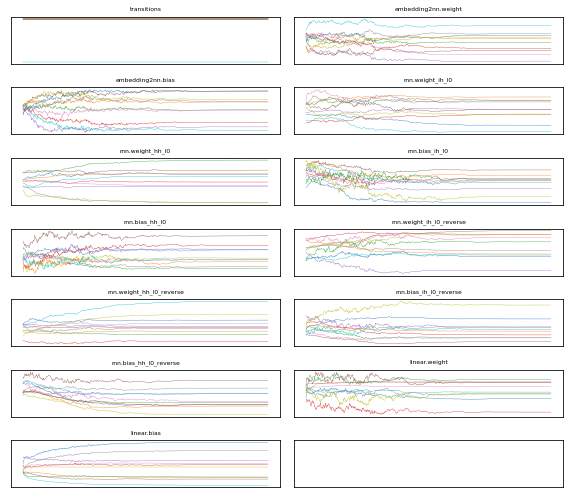

In [13]:
# 8. plot weight traces (optional)
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('resources/taggers/example-ner/weights.txt')

## Using Trained Model for Prediction  <a class="anchor" id="predict"></a>

In [14]:
import flair, torch
device = 'cuda:2'
flair.device = torch.device(device)
from flair.data import Sentence
from flair.models import SequenceTagger

In [15]:
# load the model you trained
print('Loading model...')
model = SequenceTagger.load('resources/taggers/example-ner/best-model.pt')
print('done.')

Loading model...
2020-04-04 13:06:22,953 loading file resources/taggers/example-ner/best-model.pt
done.


In [16]:
# create example sentence
sentence = Sentence('Москва - город в России')

# predict tags and print
model.predict(sentence)

print(sentence.to_tagged_string())
# Expected output: `Москва <S-Geo> - город в России <S-Geo>`

Москва <S-Geo> - город в России <S-Geo>


In [17]:
from collections import OrderedDict
from tqdm import tqdm

def flair_parse(sents):

    sents = [' '.join(sent) for sent in sents]
    
    for idx, sent in enumerate(tqdm(sents)):
        sent = Sentence(sent)
        model.predict(sent)
        sent = sent.to_tagged_string().split()
        last_idx = len(sent) - 1

        res = []
        for idx, token in enumerate(sent, start=1):
            if not token.startswith('<'):
                next_token = sent[idx] if idx <= last_idx else ''
                res.append({
                    'ID': str(idx),
                    'FORM': token,
                    'LEMMA': None,
                    'UPOS': None,
                    'XPOS': None,
                    'FEATS': OrderedDict(),
                    'HEAD': None,
                    'DEPREL': None,
                    'DEPS': None,
                    'MISC': OrderedDict(
                        [('NE', next_token[3:-1])] if next_token.startswith('<') else []
                    )
                })

        yield res

## Prediction and Saving Results to CONLL-U  <a class="anchor" id="save"></a>

In [18]:
from corpuscula import Conllu

Conllu.save(flair_parse(parsed_corpus_test), 'flair_syntagrus.conllu',
            fix=True, log_file=None)

100%|██████████| 3798/3798 [00:07<00:00, 503.58it/s]
